In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import networkx as nx
import pandas as pd
from tqdm import tqdm

import csv

import os

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model

In [2]:
# move up two directories to access the data

os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
os.chdir('model')
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\caele\Documents\miller-lab-final\model


In [3]:
# load fiducial_network.csv
id, reliability, pset, amp, dur, l_kernel, r_kernel = tuple(pd.read_csv('fiducial_network.csv'))
Wji = np.load(f'Wji_{id}.npy')

str_to_arr = lambda s, d: np.array([float(x) for x in s.removeprefix('[').removesuffix(']').split(d)])

# print all
print(f"id: {id}")
reliability = float(reliability)
print(f"reliability: {reliability}")
pset = str_to_arr(pset, None)
print(f"pset: {pset}")
amp = float(amp)
print(f"amp: {amp}")
dur = float(dur)
print(f"dur: {dur}")
l_kernel = str_to_arr(l_kernel, ',')
r_kernel = str_to_arr(r_kernel, ',')
print(f"l_kernel: {l_kernel}")
print(f"r_kernel: {r_kernel}")

id: 725
reliability: 1.0
pset: [ 1.00000000e-02  1.00000000e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.19792554e+01  4.36437108e+01 -4.75062770e+00 -1.03428554e+01
  7.39000000e+00  1.04790000e+02]
amp: 10.12
dur: 0.001
l_kernel: [0.64043 1.24114 1.14783 1.18245 0.78815]
r_kernel: [0.22043 0.76899 0.75818 2.74219 0.51021]


In [4]:
numPairs = Wji.shape[-1]
print(f"numPairs: {numPairs}")
dt = 1e-5

numPairs: 5


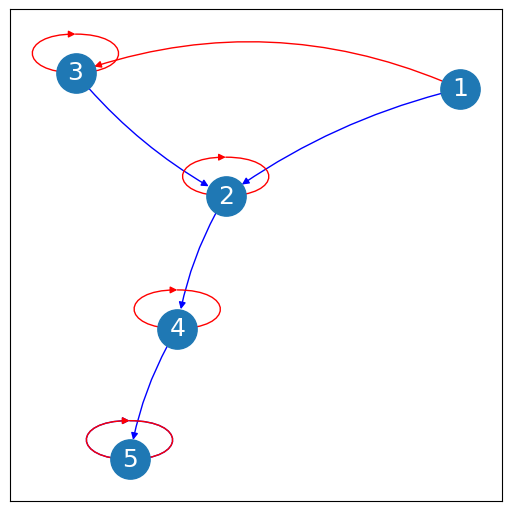

reliability: 1.0


In [5]:
l_stim = np.ones((numPairs)) * amp * l_kernel
l_stim = np.repeat(l_stim[:, np.newaxis], int(dur/dt), axis=1)
r_stim = np.ones((numPairs)) * amp * r_kernel
r_stim = np.repeat(r_stim[:, np.newaxis], int(dur/dt), axis=1)
stim_map = {'L': l_stim, 'R': r_stim}
FSM = lrt.make_FSM(numPairs, pset, Wji, stim_map, 2, dt=dt)
fig = lrt.plot_FSM(FSM)
plt.show()

# check reliability
seq_len = 6
sequences = lrt.make_all_sequences(seq_len, ['L', 'R'])
reliability = lrt.FSM_reliability(sequences, FSM)
print(f"reliability: {reliability}")

### make psychometric curves

Text(0, 0.5, 'P(choose L)')

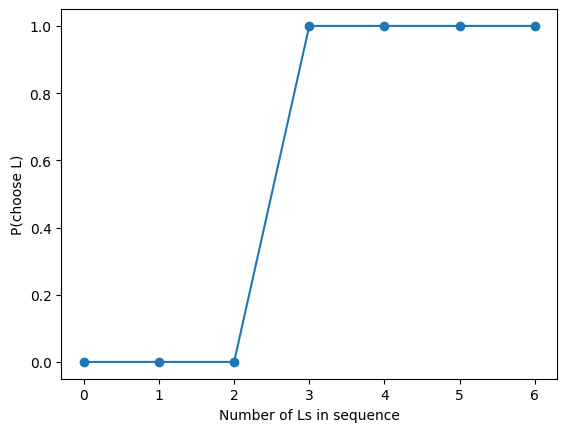

In [6]:
def psychometric_curve(sequences, FSM):
    seq_len = len(sequences[0])
    # trace all sequences on the graph
    nodes_dict = {node: [] for node in list(FSM.nodes)}
    for seq in sequences:
        # start at the beginning
        current_node = 1
        # trace the sequence
        for letter in seq:
            for edge in FSM.out_edges(current_node, keys=True):
                if FSM.edges[edge]['label'] == letter:
                    # move to the next node
                    current_node = edge[1]
                    break
        nodes_dict[current_node].append(seq.count('L'))

    left_counts = np.zeros(seq_len + 1)
    left_choices = np.zeros(seq_len + 1)
    for node in nodes_dict:
        # is the node a L or R node? based on frequency
        num_above = sum([1 for seq in nodes_dict[node] if seq > seq_len/2])
        num_below = sum([1 for seq in nodes_dict[node] if seq < seq_len/2])
        if num_above == num_below:
            continue
        node_label = num_below < num_above # True if L, False if R
        for seq in nodes_dict[node]:
            left_counts[seq] += 1
            left_choices[seq] += node_label

    return left_choices / left_counts

p_left = psychometric_curve(sequences, FSM)
plt.plot(np.arange(7), p_left, '-o')
plt.xlabel('Number of Ls in sequence')
plt.ylabel('P(choose L)')

In [7]:
test_dict = {1:{'LL':'L', 'LR':'R', 'RL':'R', 'RR':'R'}, 2:{'LL':'R', 'LR':'R', 'RL':'R', 'RR':'R'}}
pd.DataFrame(test_dict)

,1,2
LL,L,R
LR,R,R
RL,R,R
RR,R,R


In [8]:
# now a bunch of trials! -- keep mapping between sequence and decision
n_trials = 5
seq_len = len(sequences[0])
p_curves = np.zeros((n_trials, seq_len + 1))
reliabilities = np.zeros(n_trials)
decision_dict = {i:{} for i in range(n_trials)}
for i in tqdm(range(n_trials)):
    rng = np.random.default_rng(i)
    
    # make kernels -- same mean
    l_kernel = rng.lognormal(0, 1, numPairs)
    l_kernel = l_kernel / np.sum(l_kernel) * numPairs
    l_kernel = np.round(l_kernel, 5)
    r_kernel = rng.lognormal(0, 1, numPairs)
    r_kernel = r_kernel / np.sum(r_kernel) * numPairs
    r_kernel = np.round(r_kernel, 5)
    
    # make stimuli
    stim_map = lrt.make_stim_map(numPairs, amp, dur, l_kernel, r_kernel, dt)
    
    # make FSM
    FSM = lrt.make_FSM(numPairs, pset, Wji, stim_map, 2, dt=dt)
    
    reliabilities[i] = lrt.FSM_reliability(sequences, FSM)
    
    # pcurve and decision dictionary computations -----------------------
    # trace all sequences on the graph
    nodes_dict = {node: [] for node in list(FSM.nodes)}
    for seq in sequences:
        # start at the beginning
        current_node = 1
        # trace the sequence
        for letter in seq:
            for edge in FSM.out_edges(current_node, keys=True):
                if FSM.edges[edge]['label'] == letter:
                    # move to the next node
                    current_node = edge[1]
                    break
        nodes_dict[current_node].append(seq)

    left_counts = np.zeros(seq_len + 1)
    left_choices = np.zeros(seq_len + 1)
    for node in nodes_dict:
        # is the node a L or R node? based on frequency
        l_cue_counts = [seq.count('L') for seq in nodes_dict[node]]
        num_above = sum([1 for count in l_cue_counts if count > seq_len/2])
        num_below = sum([1 for count in l_cue_counts if count < seq_len/2])
        if num_above == num_below:
            for count in l_cue_counts:
                left_counts[count] += 1     # record distribution of `counts` terminating in current node
                left_choices[count] += 0.5   # record how many times each `count` resulted in a left decision
            for seq in nodes_dict[node]:
                decision_dict[i][seq] = 'Tie'
        else:
            left_decision = num_below < num_above # True if L, False if R
            for count in l_cue_counts:
                left_counts[count] += 1     # record distribution of `counts` terminating in current node
                left_choices[count] += left_decision   # record how many times each `count` resulted in a left decision
            # update dictionary
            for seq in nodes_dict[node]:
                decision_dict[i][seq] = 'L' if left_decision else 'R'
    
    p_curves[i] = left_choices/left_counts

df_decisions = pd.DataFrame(decision_dict)
# del decision_dict

100%|██████████| 5/5 [05:54<00:00, 70.89s/it]


In [14]:
df_decisions.head()

,0,1,2,3,4
LLLRRR,R,Tie,R,Tie,R
LLRRRR,R,Tie,R,Tie,R
LRLRRR,R,Tie,R,Tie,R
LRRLRR,R,Tie,R,Tie,R
LRRRLR,R,Tie,R,Tie,R


In [15]:
# save the dataframe
pd.to_pickle(df_decisions, 'decisions.pkl')

In [16]:
df_decisions.isna().sum(axis=0)

0    0
1    0
2    0
3    0
4    0
dtype: int64

(array([2., 0., 0., 0., 0., 2., 0., 0., 0., 1.]),
 array([0.5       , 0.52727273, 0.55454545, 0.58181818, 0.60909091,
        0.63636364, 0.66363636, 0.69090909, 0.71818182, 0.74545455,
        0.77272727]),
 <BarContainer object of 10 artists>)

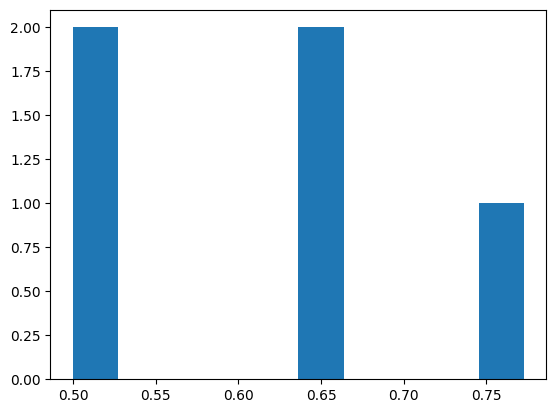

In [17]:
plt.hist(reliabilities)

In [13]:
df_decisions.isna().sum(axis=0) != 0

0    False
1    False
2    False
3    False
4    False
dtype: bool